In [1]:
!pip install torchinfo

In [2]:
!pip install lightly
!pip install torch-optimizer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="UnsupportedFieldAttributeWarning")

In [4]:
import os
import time
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from timm.models.vision_transformer import vit_base_patch32_224
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from lightly.models import utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)




Device: cuda


This section checks the current Kaggle runtime environment.
It collects and displays:
CPU model using the platform library
Total RAM (in GB) using psutil
GPU name via the nvidia-smi command (if a GPU is available)

In [5]:
import platform
import psutil
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


To ensure fully deterministic behavior across CPU, CUDA, NumPy, and Python’s built-in RNG, we manually fix all random seeds. This helps in achieving consistent results across multiple runs of training, evaluation, and debugging.

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

This code organizes PM25Vision images by air-quality labels.
It reads metadata.csv, maps PM2.5 bins to categories (Good, Moderate, Unhealthy, etc.), creates label folders, and copies images accordingly.
Finally, it prints summary counts and skipped files — readying the dataset for training.

In [7]:
import re
import shutil
import pandas as pd
from pathlib import Path


CSV_PATH = Path("/kaggle/input/pm25vision/train/metadata.csv")
IMG_DIR  = Path("/kaggle/input/pm25vision/train/images")
OUT_DIR  = Path("/kaggle/working/dataset")
OUT_DIR.mkdir(parents=True, exist_ok=True)


AQI_BINS = [
    (0, 50, "Good"),
    (51, 100, "Moderate"),
    (101, 150, "Unhealthy_Sensitive"),
    (151, 200, "Unhealthy"),
    (201, 300, "Very_Unhealthy"),
    (301, 10000, "Hazardous"),
]

def aqi_to_label(aqi: int) -> str:
    for lo, hi, label in AQI_BINS:
        if lo <= aqi <= hi:
            return label
    return None  

def bin_to_label(bin_val) -> str:
    """
    Accepts '0–50', '0-50', '0 — 50', etc.
    Extracts the LOWER numeric bound and maps to label.
    """
    s = str(bin_val).strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s*-\s*", "-", s)
    m = re.search(r"(\d+)", s)
    if not m:
        return None
    lo = int(m.group(1))
    return aqi_to_label(lo)


df = pd.read_csv(CSV_PATH)
assert "pm25_bin" in df.columns, f"Expected 'pm25_bin' column but found {df.columns}"

fname_col = "filename" if "filename" in df.columns else ("file" if "file" in df.columns else None)
if fname_col is None:
    raise ValueError(f"No image filename column found. Columns: {list(df.columns)}")

df["fname"] = df[fname_col].astype(str)
df["level"] = df["pm25_bin"].apply(bin_to_label)


df = df.dropna(subset=["level"])

print("Class counts:")
print(df["level"].value_counts(dropna=False))


for _, _, label in AQI_BINS:
    (OUT_DIR / label).mkdir(parents=True, exist_ok=True)

missing = 0
copied  = 0
valid_labels = {b[2] for b in AQI_BINS}

for _, row in df.iterrows():
    src = IMG_DIR / row["fname"]
    if not src.exists():
        missing += 1
        continue

    if row["level"] not in valid_labels:
        continue

    dst = OUT_DIR / row["level"] / src.name
    shutil.copy2(src, dst)
    copied += 1

print(f"✅ Done! Copied: {copied} | Missing files skipped: {missing}")
print(f"Output root: {OUT_DIR}")


Class counts:
level
Good                   1780
Moderate               1780
Unhealthy_Sensitive    1780
Unhealthy              1780
Very_Unhealthy          822
Hazardous               356
Name: count, dtype: int64
✅ Done! Copied: 8298 | Missing files skipped: 0
Output root: /kaggle/working/dataset


This block organizes the test images into the same labeled structure as the training dataset.
It reads metadata.csv, maps PM2.5 bins to air-quality categories, and copies each image into its respective label folder under /kaggle/working/dataset/.
Duplicate files are checked and renamed if needed, while missing images are skipped.
Finally, it prints a summary of copied, skipped, and renamed files.

In [8]:
TEST_CSV_PATH = Path("/kaggle/input/pm25vision/test/metadata.csv")
TEST_IMG_DIR  = Path("/kaggle/input/pm25vision/test/images")
OUT_DIR       = Path("/kaggle/working/dataset") 


AQI_BINS = [
    (0, 50, "Good"),
    (51, 100, "Moderate"),
    (101, 150, "Unhealthy_Sensitive"),
    (151, 200, "Unhealthy"),
    (201, 300, "Very_Unhealthy"),
    (301, 10000, "Hazardous"),
]

def aqi_to_label(aqi: int) -> str | None:
    for lo, hi, label in AQI_BINS:
        if lo <= aqi <= hi:
            return label
    return None 

def bin_to_label(bin_val) -> str | None:
    s = str(bin_val).strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s*-\s*", "-", s)
    m = re.search(r"(\d+)", s)
    if not m:
        return None  
    lo = int(m.group(1))
    return aqi_to_label(lo)


df_t = pd.read_csv(TEST_CSV_PATH)
assert "pm25_bin" in df_t.columns, f"Expected 'pm25_bin' in TEST CSV, got: {df_t.columns}"

fname_col_t = "filename" if "filename" in df_t.columns else ("file" if "file" in df_t.columns else None)
if fname_col_t is None:
    raise ValueError(f"No image filename column in TEST CSV. Columns: {list(df_t.columns)}")

df_t["fname"] = df_t[fname_col_t].astype(str)
df_t["level"] = df_t["pm25_bin"].apply(bin_to_label)

missing, copied, skipped_same, renamed_dupe = 0, 0, 0, 0
valid_labels = {b[2] for b in AQI_BINS}

for _, r in df_t.iterrows():
    src = TEST_IMG_DIR / r["fname"]
    if not src.exists():
        missing += 1
        continue

 
    if r["level"] not in valid_labels:
        continue

    dest_dir = OUT_DIR / r["level"]
    dest_dir.mkdir(parents=True, exist_ok=True)

    dst = dest_dir / src.name
    if dst.exists():
     
        if os.path.getsize(dst) == os.path.getsize(src):
            skipped_same += 1
            continue
        dst = dest_dir / f"test__{src.name}"
        renamed_dupe += 1

    shutil.copy2(src, dst)
    copied += 1

print("✅ TEST merge complete.")
print(f"Copied: {copied} | Missing files: {missing} | Skipped exact-duplicates: {skipped_same} | Renamed (name clash): {renamed_dupe}")
print(f"Merged into: {OUT_DIR}")


✅ TEST merge complete.
Copied: 2905 | Missing files: 0 | Skipped exact-duplicates: 16 | Renamed (name clash): 0
Merged into: /kaggle/working/dataset


This code counts the number of images in each air-quality class under /kaggle/working/dataset/.
It prints per-class image totals and the overall dataset size — useful for confirming that all files were organized correctly.

In [9]:
from pathlib import Path
import shutil

OUT_DIR = Path("/kaggle/working/dataset")


unknown_dir = OUT_DIR / "Unknown"
if unknown_dir.exists() and unknown_dir.is_dir():
    shutil.rmtree(unknown_dir)


class_counts = {}
for sub in OUT_DIR.iterdir():
    if sub.is_dir():
        class_counts[sub.name] = len(list(sub.glob("*")))

print(" Image count per class:\n")

for k, v in sorted(class_counts.items()):
    print(f"{k:20s}: {v}")

print("\nTotal images:", sum(class_counts.values()))

 Image count per class:

Good                : 2408
Hazardous           : 481
Moderate            : 2407
Unhealthy           : 2407
Unhealthy_Sensitive : 2393
Very_Unhealthy      : 1007

Total images: 11103


This code scans the organized dataset under /kaggle/working/dataset/ and builds a DataFrame listing each image path and its label.
It filters valid image formats (.jpg, .jpeg, .png), counts total samples per class, and defines a helper function to load images as RGB arrays.
Useful for quick checks, visualization, or later data-loader creation.

In [10]:
from pathlib import Path
from PIL import Image

BASE_DIR = Path("/kaggle/working/dataset")  
assert BASE_DIR.exists(), BASE_DIR

rows = []
for label_dir in sorted([p for p in BASE_DIR.iterdir() if p.is_dir()]):
    label = label_dir.name
    for p in label_dir.glob("*"):
        if p.suffix.lower() not in {".jpg", ".jpeg", ".png"}:
            continue
        rows.append({"path": str(p), "label": label})

df = pd.DataFrame(rows)
print("Total images indexed:", len(df))
print("Class balance:\n", df["label"].value_counts())

def load_rgb(path):
    with Image.open(path) as im:
        im = im.convert("RGB")
        return np.array(im)

df.head(20)

Total images indexed: 11103
Class balance:
 label
Good                   2408
Moderate               2407
Unhealthy              2407
Unhealthy_Sensitive    2393
Very_Unhealthy         1007
Hazardous               481
Name: count, dtype: int64


,path,label
0,/kaggle/working/dataset/Good/1441065216294380.jpg,Good
1,/kaggle/working/dataset/Good/179010510781782.jpg,Good
2,/kaggle/working/dataset/Good/1333686144497071.jpg,Good
3,/kaggle/working/dataset/Good/499002188197423.jpg,Good
4,/kaggle/working/dataset/Good/271072584759435.jpg,Good
5,/kaggle/working/dataset/Good/932161130972953.jpg,Good
6,/kaggle/working/dataset/Good/843943872864453.jpg,Good
7,/kaggle/working/dataset/Good/593760690012721.jpg,Good
8,/kaggle/working/dataset/Good/1557187125097899.jpg,Good
9,/kaggle/working/dataset/Good/1188685195916719.jpg,Good


This block defines all required file paths for downstream tasks, including the BYOL checkpoint and embedding file from pretext training, as well as output locations for the linear probe, fine-tuned model, and training logs. It also selects the compute device (CPU/GPU).

In [11]:
data_dir = "/kaggle/working/dataset"

# MAE pretext outputs
checkpoint_path = "/kaggle/input/output-of-mae-pretest-task/mae_checkpoint.pth"
embedding_path  = "/kaggle/input/output-of-mae-pretest-task/mae_embeddings.npz"

# Downstream outputs
linear_classifier_path = "/kaggle/working/mae_linear_classifier.pth"
finetune_model_path    = "/kaggle/working/mae_finetuned_model.pth"

batch_size   = 64
num_workers  = 2
random_state = 42
linear_epochs   = 50
finetune_epochs = 50
learning_rate_linear   = 1e-3
weight_decay_linear    = 1e-4
learning_rate_finetune = 3e-4
weight_decay_finetune  = 1e-4


This code visualizes the number of images in each air-quality category using a Seaborn bar chart.
It helps verify dataset balance and ensure all classes are properly represented before training.

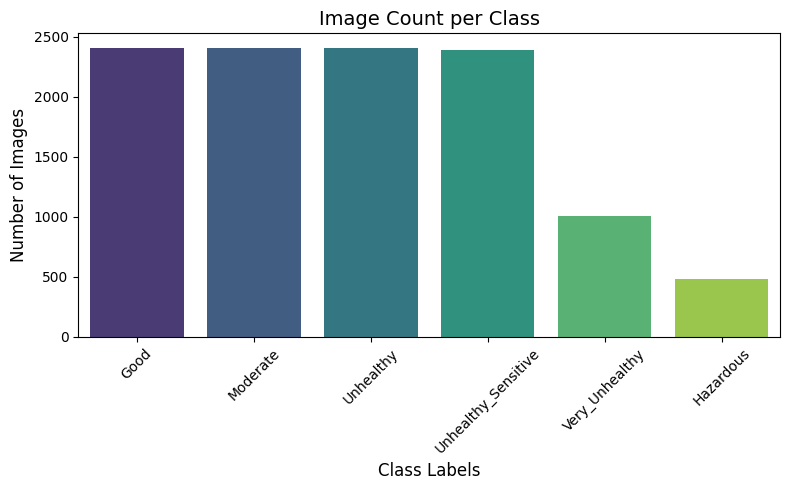

In [12]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df["label"].value_counts().index,
            y=df["label"].value_counts().values,
            palette="viridis")
plt.title("Image Count per Class", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This code displays a small gallery showing two random sample images from each air-quality class.
It helps visually verify the dataset and observe differences across categories such as Good, Moderate, and Unhealthy.
Useful for quick quality checks and understanding visual variation before model training.

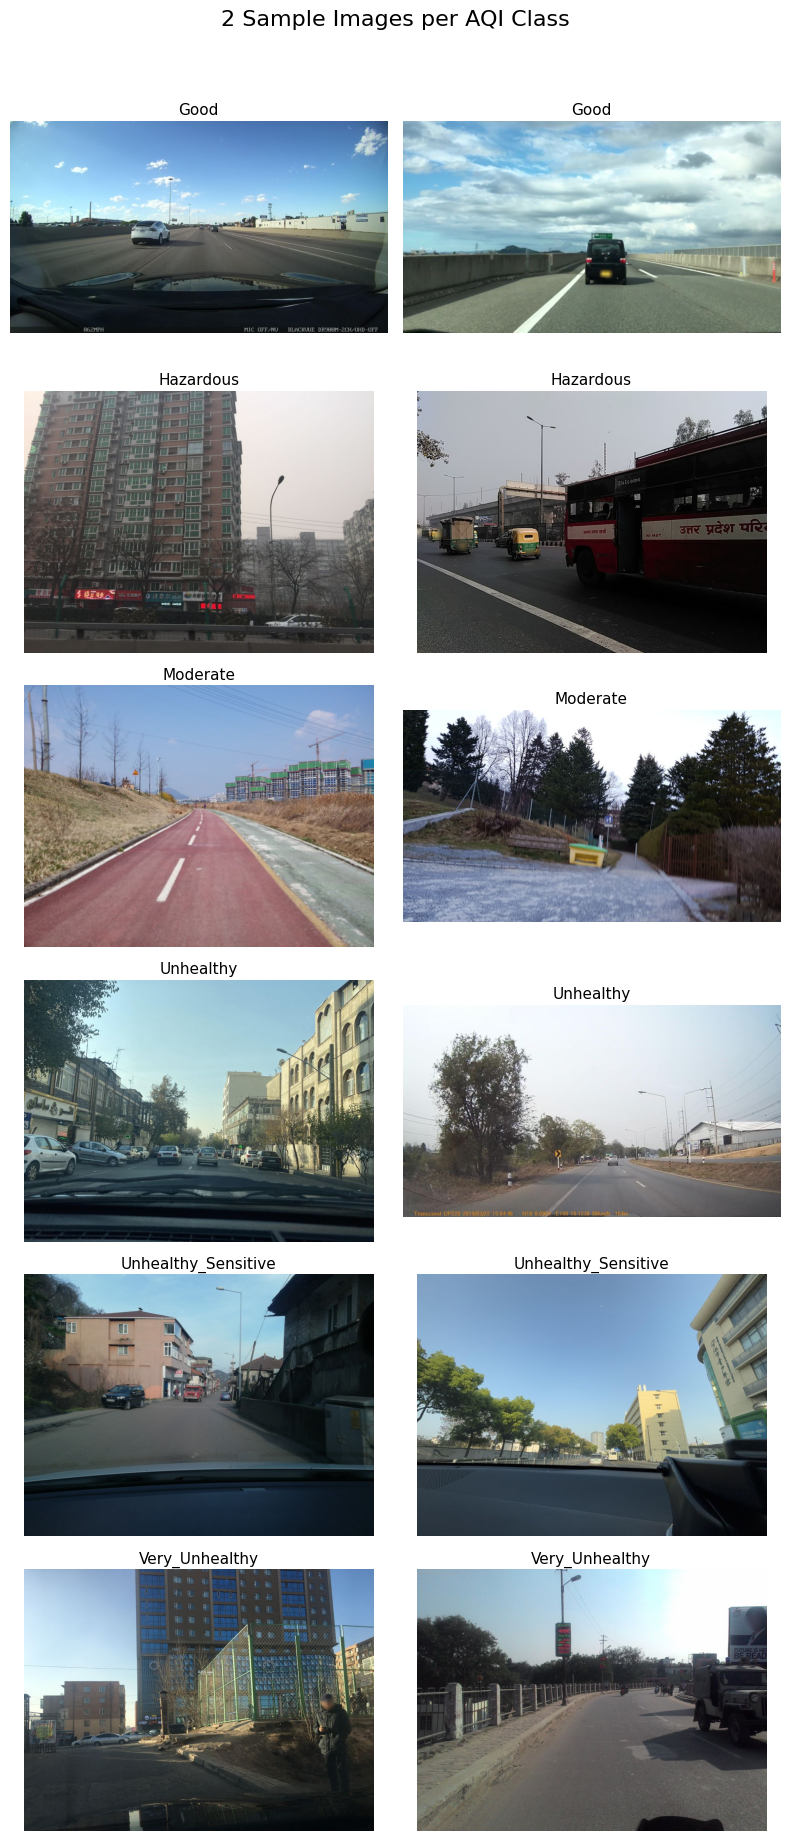

In [13]:
from PIL import Image

classes = sorted(df["label"].unique())

N_PER_CLASS = 2

plt.figure(figsize=(N_PER_CLASS * 4, len(classes) * 3))

for i, lbl in enumerate(classes):
    subset = df[df["label"] == lbl]["path"].tolist()
    sample_paths = random.sample(subset, min(N_PER_CLASS, len(subset)))
    
    for j, path in enumerate(sample_paths):
        idx = i * N_PER_CLASS + j + 1
        plt.subplot(len(classes), N_PER_CLASS, idx)
        
        img = Image.open(path)
        plt.imshow(img)
        plt.axis("off")
        
        plt.title(lbl, fontsize=11, pad=4)

plt.suptitle("2 Sample Images per AQI Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

This block loads all image file paths and labels from the dataset directory, filtering only the specified PM2.5 classes. After loading, it prints the total number of images and the distribution across all air-quality categories to verify correct data preparation.

In [14]:
def load_split(split_dir, selected_classes=None):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        if selected_classes and class_name not in selected_classes:
            continue

        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

    return pd.DataFrame({"file_path": file_paths, "label": labels})


PM25_CLASSES = [
    "Good",
    "Moderate",
    "Unhealthy_Sensitive",
    "Unhealthy",
    "Very_Unhealthy",
    "Hazardous",
]

data = load_split(data_dir, selected_classes=PM25_CLASSES)

print("Total images:", len(data))
print("\nClass counts:")
print(data["label"].value_counts())


Total images: 11103

Class counts:
label
Good                   2408
Moderate               2407
Unhealthy              2407
Unhealthy_Sensitive    2393
Very_Unhealthy         1007
Hazardous               481
Name: count, dtype: int64


This block splits the dataset into train, validation, and test partitions while preserving class balance using stratified sampling. First, 70% is used for training, and the remaining 30% is evenly divided into validation and test sets. The final split sizes are printed for verification.

In [15]:
train_dataframe, temp_dataframe = train_test_split(
    data,
    test_size=0.20,                 # 20% → temp (val + test)
    stratify=data["label"],
    random_state=random_state,
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=0.50,                 # half of 20% → 10% val, 10% test
    stratify=temp_dataframe["label"],
    random_state=random_state,
)

print("Train size      :", len(train_dataframe))
print("Validation size :", len(validation_dataframe))
print("Test size       :", len(test_dataframe))


Train size      : 8882
Validation size : 1110
Test size       : 1111


This block defines a labeled image dataset class for supervised learning, applies a standard ImageNet-style transform, and constructs train/validation/test datasets with DataLoaders. It also maps class names to numeric indices and prints the final class-to-index mapping used for classification.

In [16]:
class LabeledImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.file_paths = dataframe["file_path"].values
        self.labels_str = dataframe["label"].values
        self.transform  = transform

        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(self.labels_str)))}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        self.labels = np.array([self.class_to_idx[lbl] for lbl in self.labels_str])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        image_path = self.file_paths[index]
        img = PIL.Image.open(image_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = self.labels[index]
        return img, label


embedding_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

train_dataset = LabeledImageDataset(train_dataframe, transform=embedding_transform)
val_dataset   = LabeledImageDataset(validation_dataframe, transform=embedding_transform)
test_dataset  = LabeledImageDataset(test_dataframe, transform=embedding_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

num_classes = len(train_dataset.class_to_idx)
print("Number of classes:", num_classes)
print("Class to index mapping:", train_dataset.class_to_idx)


Number of classes: 6
Class to index mapping: {'Good': 0, 'Hazardous': 1, 'Moderate': 2, 'Unhealthy': 3, 'Unhealthy_Sensitive': 4, 'Very_Unhealthy': 5}


This block rebuilds the BYOL model with a ResNet-50 backbone, loads the pretrained BYOL checkpoint, and extracts the backbone as the frozen encoder for downstream classification. It also loads the saved embedding file to determine the feature dimension used for later models.

In [17]:
class MAE(nn.Module):
    def __init__(self, vit):
        super().__init__()

        decoder_dim = 512
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_embed.patch_size[0]

        self.backbone = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = self.backbone.sequence_length
        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches,
            patch_size=self.patch_size,
            embed_dim=vit.embed_dim,
            decoder_embed_dim=decoder_dim,
            decoder_depth=1,
            decoder_num_heads=16,
            mlp_ratio=4.0,
            proj_drop_rate=0.0,
            attn_drop_rate=0.0,
        )

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.decoder.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))
        x_decoded = self.decoder.decode(x_masked)
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def forward(self, images):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )
        patches = utils.patchify(images, self.patch_size)
        target = utils.get_at_index(patches, idx_mask - 1)
        return x_pred, target


vit = vit_base_patch32_224()
mae_model = MAE(vit).to(device)

def load_clean_state_dict(model, state_dict):
    clean_sd = {}
    for k, v in state_dict.items():
        if "total_ops" in k or "total_params" in k:
            continue
        clean_sd[k] = v
    return clean_sd

checkpoint = torch.load(checkpoint_path, map_location=device)
state = checkpoint["model_state_dict"]
clean_state = load_clean_state_dict(mae_model, state)
missing_keys, unexpected_keys = mae_model.load_state_dict(clean_state, strict=False)

print(f"Loaded MAE checkpoint from epoch {checkpoint.get('epoch', 'N/A')}")
print(f"Removed invalid THOP keys: {len(state) - len(clean_state)}")
print("Missing:", missing_keys)
print("Unexpected:", unexpected_keys)

mae_model.eval()


class MAEBackbone(nn.Module):
    """Wrapper so encoder(images) matches encoder API."""
    def __init__(self, mae):
        super().__init__()
        self.mae = mae
        self.sequence_length = mae.sequence_length
        self.feature_dim = mae.backbone.vit.embed_dim

    def forward(self, x):
        B = x.size(0)
        seq_len = self.sequence_length
        idx_keep = torch.arange(seq_len).unsqueeze(0).repeat(B, 1).to(x.device)
        feats = self.mae.forward_encoder(images=x, idx_keep=idx_keep)
        cls_feats = feats[:, 0, :]   # [B, feature_dim]
        return cls_feats


encoder = MAEBackbone(mae_model).to(device)
encoder.eval()

mae_embeddings = np.load(embedding_path)
embeddings = mae_embeddings["embeddings"]
feature_dim = embeddings.shape[1]

print("Feature dim (from embeddings):", feature_dim)


Loaded MAE checkpoint from epoch 100
Removed invalid THOP keys: 352
Missing: []
Unexpected: []
Feature dim (from embeddings): 768


This block uses the frozen BYOL encoder to generate feature vectors for the train, validation, and test splits. It runs the encoder in evaluation mode, collects all embeddings with their labels, and prints the resulting feature shapes. These features are later used for linear probes and shallow classifiers.

In [18]:
def extract_features(encoder, dataloader, device):
    encoder.eval()
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            feats = encoder(images).flatten(start_dim=1)
            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

    all_feats = np.concatenate(all_feats, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_feats, all_labels

print("Extracting frozen features for train/val/test (for shallow heads)...")
X_tr, y_tr = extract_features(encoder, train_loader, device)
X_va, y_va = extract_features(encoder, val_loader, device)
X_te, y_te = extract_features(encoder, test_loader, device)

print("Train features:", X_tr.shape)
print("Val features  :", X_va.shape)
print("Test features :", X_te.shape)


Extracting frozen features for train/val/test (for shallow heads)...
Train features: (8882, 768)
Val features  : (1110, 768)
Test features : (1111, 768)


This block defines and trains a linear classifier on top of the frozen BYOL encoder. It tracks train/validation loss, accuracy, and per-epoch time to build learning curves. The best-performing linear model (based on validation accuracy) is saved for downstream evaluation.

In [19]:
linear_train_loss_list = []
linear_val_loss_list = []
linear_train_acc_list = []
linear_val_acc_list = []
linear_epoch_time_list = []

class LinearProbe(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

linear_model = LinearProbe(feature_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(linear_model.parameters(),
                              lr=learning_rate_linear,
                              weight_decay=weight_decay_linear)

def run_linear_probe(encoder, clf, train_loader, val_loader, device, epochs):
    encoder.eval()
    best_val_acc = 0.0

    for epoch in range(epochs):
        epoch_start_time = time.time()

        clf.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                feats = encoder(images).flatten(start_dim=1)

            outputs = clf(feats)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total

        clf.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                feats = encoder(images).flatten(start_dim=1)
                outputs = clf(feats)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - epoch_start_time

        linear_train_loss_list.append(train_loss)
        linear_val_loss_list.append(val_loss)
        linear_train_acc_list.append(train_acc)
        linear_val_acc_list.append(val_acc)
        linear_epoch_time_list.append(epoch_time)

        print(f"[Linear] Epoch {epoch+1:02d} | "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, "
              f"time={epoch_time:.2f}s")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(clf.state_dict(), linear_classifier_path)

    return


run_linear_probe(encoder, linear_model, train_loader, val_loader, device, linear_epochs)
print("Best linear-probe classifier saved to:", linear_classifier_path)


[Linear] Epoch 01 | train_loss=1.6517, train_acc=0.2684, val_loss=1.6110, val_acc=0.2838, time=70.24s
[Linear] Epoch 02 | train_loss=1.6071, train_acc=0.3017, val_loss=1.5802, val_acc=0.3324, time=70.42s
[Linear] Epoch 03 | train_loss=1.5877, train_acc=0.3142, val_loss=1.5626, val_acc=0.3450, time=71.14s
[Linear] Epoch 04 | train_loss=1.5713, train_acc=0.3245, val_loss=1.5507, val_acc=0.3676, time=70.82s
[Linear] Epoch 05 | train_loss=1.5593, train_acc=0.3353, val_loss=1.5544, val_acc=0.3568, time=70.30s
[Linear] Epoch 06 | train_loss=1.5541, train_acc=0.3406, val_loss=1.5488, val_acc=0.3640, time=69.67s
[Linear] Epoch 07 | train_loss=1.5458, train_acc=0.3505, val_loss=1.5370, val_acc=0.3748, time=69.41s
[Linear] Epoch 08 | train_loss=1.5401, train_acc=0.3527, val_loss=1.5341, val_acc=0.3604, time=70.54s
[Linear] Epoch 09 | train_loss=1.5328, train_acc=0.3514, val_loss=1.5289, val_acc=0.3640, time=70.14s
[Linear] Epoch 10 | train_loss=1.5295, train_acc=0.3557, val_loss=1.5187, val_acc=

This block loads the best saved linear classifier and evaluates it on the test set using the frozen BYOL encoder. It computes test loss, accuracy, inference time, full classification report, and confusion matrix. It also calculates macro ROC–AUC and plots per-class ROC curves to thoroughly assess downstream performance.

Test Loss: 1.489, Test Accuracy: 0.378
Total Test Time: 8.27 seconds for 1111 images
Average Inference Time per Image: 0.007439 s

Classification Report:
              precision    recall  f1-score   support

           0     0.3989    0.5975    0.4784       241
           1     0.3846    0.1042    0.1639        48
           2     0.2297    0.0705    0.1079       241
           3     0.3819    0.5436    0.4486       241
           4     0.3701    0.4333    0.3992       240
           5     0.4872    0.1900    0.2734       100

    accuracy                         0.3780      1111
   macro avg     0.3754    0.3232    0.3119      1111
weighted avg     0.3596    0.3780    0.3424      1111



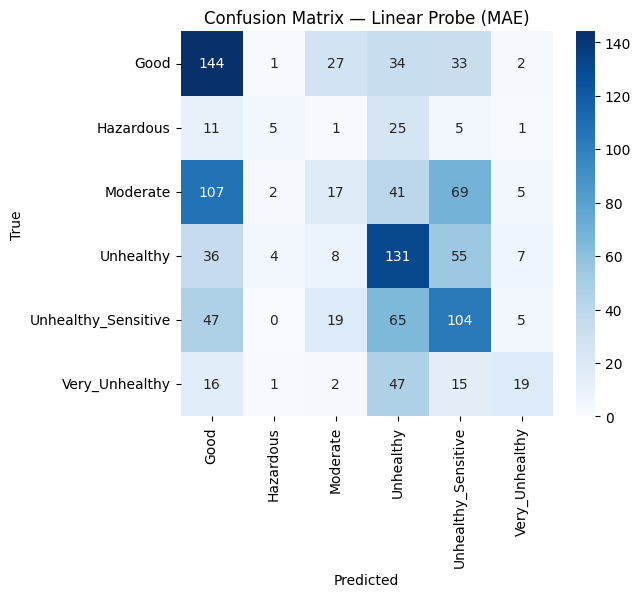

ROC–AUC (macro): 0.7157


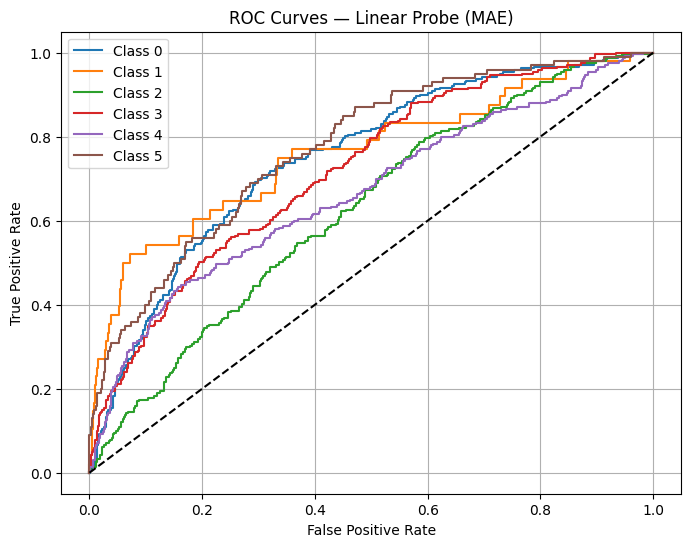

In [20]:
best_linear = LinearProbe(feature_dim, num_classes).to(device)
best_linear.load_state_dict(torch.load(linear_classifier_path, map_location=device))
best_linear.eval()
encoder.eval()

test_loss = 0.0
test_total = 0
all_preds = []
all_labels = []
all_probs = []

test_start = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        feats = encoder(images).flatten(start_dim=1)
        outputs = best_linear(feats)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        test_total += labels.size(0)

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_time = time.time() - test_start
avg_time = test_time / len(test_dataset)
test_loss /= test_total

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

linear_test_acc = accuracy_score(all_labels, all_preds)

print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {linear_test_acc:.3f}")
print(f"Total Test Time: {test_time:.2f} seconds for {len(test_dataset)} images")
print(f"Average Inference Time per Image: {avg_time:.6f} s")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
    yticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Linear Probe (MAE)")
plt.show()

roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print(f"ROC–AUC (macro): {roc_auc:.4f}")

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Linear Probe (MAE)")
plt.legend()
plt.grid(True)
plt.show()


This block evaluates the quality of the frozen BYOL embeddings using a simple k-Nearest Neighbors classifier. By testing k = 1, 5, and 20, it provides a quick, label-efficient measure of representation strength without any training.

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def knn_eval(Xtrain, ytrain, Xtest, ytest, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain, ytrain)
    ypred = knn.predict(Xtest)
    return accuracy_score(ytest, ypred)

print("\n=== k-NN Accuracy on Frozen MAE Features ===")
for k in [1, 5, 20]:
    acc = knn_eval(X_tr, y_tr, X_te, y_te, k)
    print(f"k={k:2d}: {acc:.4f}")



=== k-NN Accuracy on Frozen MAE Features ===
k= 1: 0.5185
k= 5: 0.4815
k=20: 0.4383


This block measures how well the BYOL representations perform when only a small fraction of labeled data is available. It trains a lightweight linear classifier on subsets of the training set (1% to 50%), evaluates accuracy on the test set, and plots a label-efficiency curve to show how performance scales with label availability.

 1% labels → Linear-probe accuracy = 0.2187
 5% labels → Linear-probe accuracy = 0.2187
10% labels → Linear-probe accuracy = 0.2160
25% labels → Linear-probe accuracy = 0.2160
50% labels → Linear-probe accuracy = 0.2331


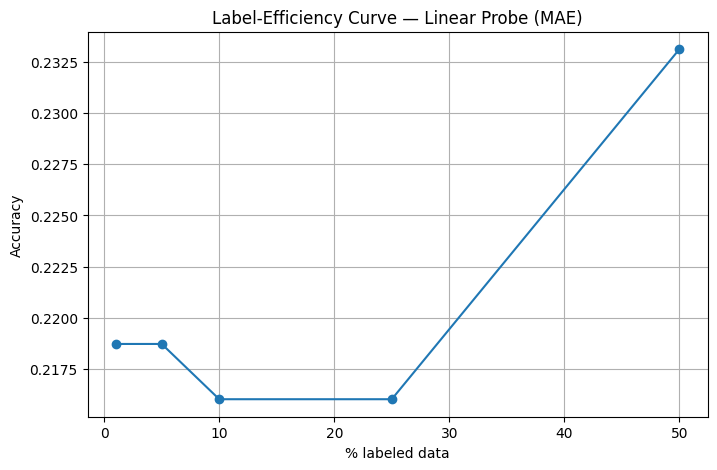

In [22]:
fractions = [0.01, 0.05, 0.10, 0.25, 0.50]
efficiency_results = {}

for frac in fractions:
    n = int(len(X_tr) * frac)

    idx = np.random.choice(len(X_tr), size=n, replace=False)
    X_sub = X_tr[idx]
    y_sub = y_tr[idx]

    clf = LinearProbe(feature_dim, num_classes).to(device)
    opt = torch.optim.AdamW(clf.parameters(), lr=1e-3)

    for epoch in range(5):
        clf.train()
        feats = torch.tensor(X_sub, dtype=torch.float32).to(device)
        labels = torch.tensor(y_sub, dtype=torch.long).to(device)
        outputs = clf(feats)
        loss = criterion(outputs, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

    clf.eval()
    Xtest = torch.tensor(X_te, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = clf(Xtest).cpu().numpy()
    preds = out.argmax(axis=1)

    acc = accuracy_score(y_te, preds)
    efficiency_results[frac] = acc
    print(f"{int(frac*100):2d}% labels → Linear-probe accuracy = {acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot([f*100 for f in fractions],
         [efficiency_results[f] for f in fractions],
         marker='o')
plt.xlabel("% labeled data")
plt.ylabel("Accuracy")
plt.title("Label-Efficiency Curve — Linear Probe (MAE)")
plt.grid(True)
plt.show()


This block evaluates several classical shallow models—MLP, SVM, Decision Tree, and Random Forest—using the frozen BYOL embeddings. Each classifier is trained on the training features, tested on the test set, and its accuracy and classification report are printed. A summary table of all shallow-head performances is shown at the end.

In [23]:
results_shallow = {}

mlp_clf = MLPClassifier(hidden_layer_sizes=(256,), max_iter=200, random_state=42)
mlp_clf.fit(X_tr, y_tr)
y_pred_mlp = mlp_clf.predict(X_te)
acc_mlp = accuracy_score(y_te, y_pred_mlp)
results_shallow["MLP"] = acc_mlp
print("\n[MLP] Test Accuracy:", acc_mlp)
print(classification_report(y_te, y_pred_mlp, digits=4))

svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_tr, y_tr)
y_pred_svm = svm_clf.predict(X_te)
acc_svm = accuracy_score(y_te, y_pred_svm)
results_shallow["SVM"] = acc_svm
print("\n[SVM] Test Accuracy:", acc_svm)
print(classification_report(y_te, y_pred_svm, digits=4))

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_tr, y_tr)
y_pred_dt = dt_clf.predict(X_te)
acc_dt = accuracy_score(y_te, y_pred_dt)
results_shallow["DecisionTree"] = acc_dt
print("\n[Decision Tree] Test Accuracy:", acc_dt)
print(classification_report(y_te, y_pred_dt, digits=4))

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf_clf.fit(X_tr, y_tr)
y_pred_rf = rf_clf.predict(X_te)
acc_rf = accuracy_score(y_te, y_pred_rf)
results_shallow["RandomForest"] = acc_rf
print("\n[Random Forest] Test Accuracy:", acc_rf)
print(classification_report(y_te, y_pred_rf, digits=4))

print("\n=== Shallow Head Summary (Frozen MAE Features) ===")
for k, v in results_shallow.items():
    print(f"{k:15s}: {v:.4f}")



[MLP] Test Accuracy: 0.48064806480648065
              precision    recall  f1-score   support

           0     0.4639    0.5062    0.4841       241
           1     0.7419    0.4792    0.5823        48
           2     0.3373    0.3568    0.3468       241
           3     0.6497    0.5311    0.5845       241
           4     0.4603    0.4583    0.4593       240
           5     0.5159    0.6500    0.5752       100

    accuracy                         0.4806      1111
   macro avg     0.5282    0.4969    0.5054      1111
weighted avg     0.4926    0.4806    0.4832      1111


[SVM] Test Accuracy: 0.3114311431143114
              precision    recall  f1-score   support

           0     0.3462    0.4855    0.4041       241
           1     0.0000    0.0000    0.0000        48
           2     0.3059    0.1079    0.1595       241
           3     0.2940    0.6307    0.4011       241
           4     0.2982    0.2125    0.2482       240
           5     0.0000    0.0000    0.0000      

This block builds a fine-tuning model by attaching a classifier to the BYOL-pretrained backbone and unfreezing all backbone layers for end-to-end training. It sets separate learning rates for backbone and classifier, defines the training loop with validation monitoring, and saves the best fine-tuned model based on validation accuracy.

In [24]:
class FineTuneModel(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        feats = self.encoder(x).flatten(start_dim=1)
        out = self.fc(feats)
        return out


finetune_model = FineTuneModel(encoder, feature_dim, num_classes).to(device)

# Option: fine-tune whole encoder + head
finetune_criterion = nn.CrossEntropyLoss()
finetune_optimizer = torch.optim.AdamW(
    finetune_model.parameters(),
    lr=learning_rate_finetune,
    weight_decay=weight_decay_finetune,
)

best_ft_val_acc = 0.0

print("\nStarting fine-tuning (encoder + head) with MAE features...\n")
for epoch in range(finetune_epochs):
    epoch_start = time.time()

    finetune_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = finetune_model(images)
        loss = finetune_criterion(outputs, labels)

        finetune_optimizer.zero_grad()
        loss.backward()
        finetune_optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    finetune_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = finetune_model(images)
            loss = finetune_criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    epoch_time = time.time() - epoch_start

    print(f"[Fine-Tune] Epoch {epoch+1:02d} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, "
          f"time={epoch_time:.2f}s")

    if val_acc > best_ft_val_acc:
        best_ft_val_acc = val_acc
        torch.save(finetune_model.state_dict(), finetune_model_path)

print("Best fine-tuned model saved to:", finetune_model_path)



Starting fine-tuning (encoder + head) with MAE features...

[Fine-Tune] Epoch 01 | train_loss=1.5689, train_acc=0.3213, val_loss=1.5434, val_acc=0.3342, time=74.32s
[Fine-Tune] Epoch 02 | train_loss=1.4132, train_acc=0.4081, val_loss=1.3857, val_acc=0.4189, time=72.19s
[Fine-Tune] Epoch 03 | train_loss=1.3019, train_acc=0.4524, val_loss=1.3099, val_acc=0.4261, time=73.79s
[Fine-Tune] Epoch 04 | train_loss=1.2131, train_acc=0.4955, val_loss=1.2471, val_acc=0.4946, time=73.13s
[Fine-Tune] Epoch 05 | train_loss=1.1550, train_acc=0.5189, val_loss=1.2587, val_acc=0.4721, time=73.65s
[Fine-Tune] Epoch 06 | train_loss=1.0993, train_acc=0.5441, val_loss=1.2698, val_acc=0.4649, time=72.57s
[Fine-Tune] Epoch 07 | train_loss=1.0376, train_acc=0.5668, val_loss=1.2360, val_acc=0.5018, time=74.60s
[Fine-Tune] Epoch 08 | train_loss=0.9850, train_acc=0.5968, val_loss=1.3272, val_acc=0.4919, time=74.91s
[Fine-Tune] Epoch 09 | train_loss=0.9680, train_acc=0.5984, val_loss=1.2631, val_acc=0.5144, time=7

This block evaluates both the best linear-probe classifier and the best fine-tuned model on the test set. It computes accuracy, loss, classification reports, confusion matrices, ROC–AUC scores, and plots ROC curves. A final summary compares linear-probe, fine-tuned, and shallow-head results for a complete downstream performance overview.

Test Loss: 4.165, Test Accuracy: 0.384
Total Test Time: 8.16 seconds for 1111 images
Average Inference Time per Image: 0.007346 s

Classification Report (Linear Probe):
              precision    recall  f1-score   support

           0     0.3465    0.6929    0.4620       241
           1     0.2229    0.7292    0.3415        48
           2     0.5000    0.0083    0.0163       241
           3     0.5267    0.3278    0.4041       241
           4     0.4286    0.3750    0.4000       240
           5     0.5000    0.5400    0.5192       100

    accuracy                         0.3843      1111
   macro avg     0.4208    0.4455    0.3572      1111
weighted avg     0.4451    0.3843    0.3393      1111



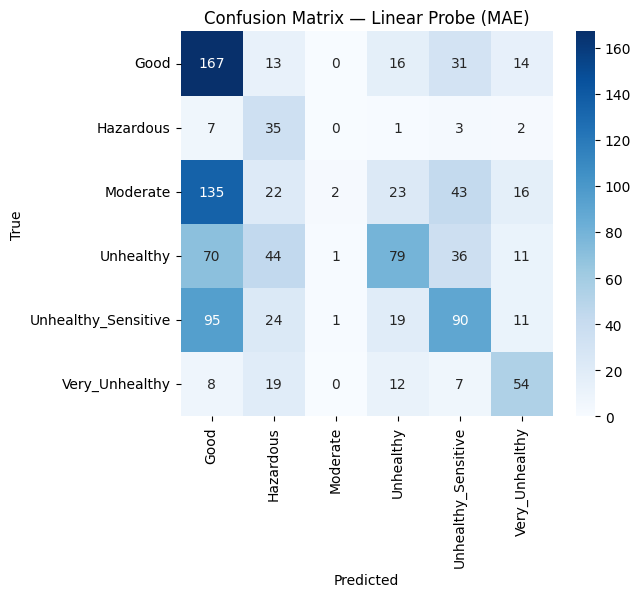

ROC–AUC (macro, Linear Probe): 0.7417


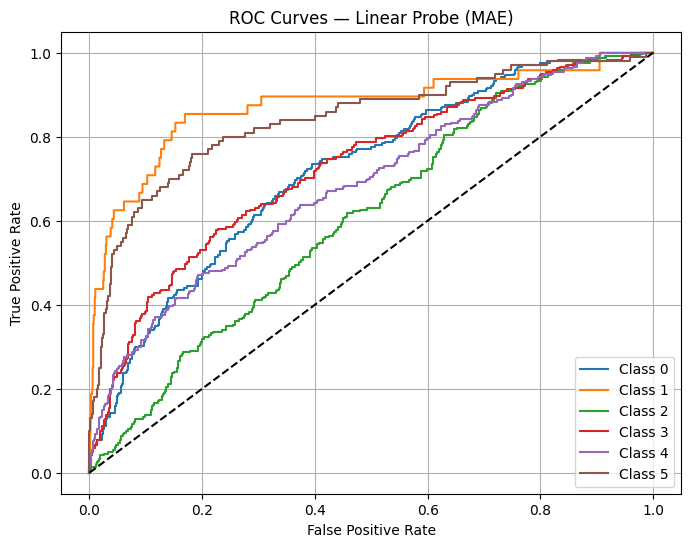


[Fine-Tune] Test Accuracy: 0.4950
              precision    recall  f1-score   support

           0     0.4418    0.5353    0.4841       241
           1     0.6571    0.4792    0.5542        48
           2     0.3612    0.3402    0.3504       241
           3     0.5808    0.6266    0.6028       241
           4     0.4916    0.4875    0.4895       240
           5     0.8136    0.4800    0.6038       100

    accuracy                         0.4950      1111
   macro avg     0.5577    0.4915    0.5141      1111
weighted avg     0.5080    0.4950    0.4958      1111



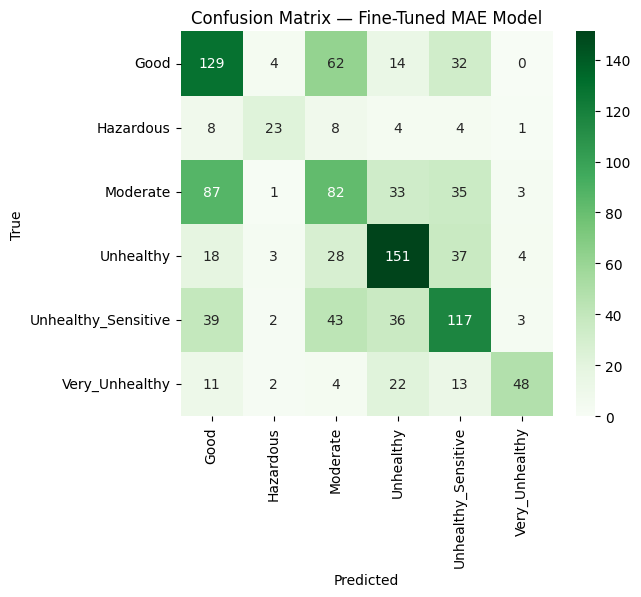


=== Summary: Linear vs Fine-Tune (Test Accuracy, MAE) ===
Linear Probe : 0.3843
Fine-Tune    : 0.4950

=== Shallow Heads (Frozen MAE Features) ===
MLP            : 0.4806
SVM            : 0.3114
DecisionTree   : 0.3186
RandomForest   : 0.4752


In [25]:
best_linear = LinearProbe(feature_dim, num_classes).to(device)
best_linear.load_state_dict(torch.load(linear_classifier_path, map_location=device))
best_linear.eval()
encoder.eval()

test_loss = 0.0
test_total = 0
all_preds = []
all_labels = []
all_probs = []

test_start = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        feats = encoder(images).flatten(start_dim=1)
        outputs = best_linear(feats)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        test_total += labels.size(0)

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_time = time.time() - test_start
avg_time = test_time / len(test_dataset)
test_loss /= test_total

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

linear_test_acc = accuracy_score(all_labels, all_preds)

print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {linear_test_acc:.3f}")
print(f"Total Test Time: {test_time:.2f} seconds for {len(test_dataset)} images")
print(f"Average Inference Time per Image: {avg_time:.6f} s\n")

print("Classification Report (Linear Probe):")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
    yticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Linear Probe (MAE)")
plt.show()

roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print(f"ROC–AUC (macro, Linear Probe): {roc_auc:.4f}")

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Linear Probe (MAE)")
plt.legend()
plt.grid(True)
plt.show()


best_finetune_model = FineTuneModel(encoder, feature_dim, num_classes).to(device)
best_finetune_model.load_state_dict(torch.load(finetune_model_path, map_location=device))
best_finetune_model.eval()

all_preds_ft = []
all_labels_ft = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_finetune_model(images)
        preds = outputs.argmax(dim=1)

        all_preds_ft.extend(preds.cpu().numpy())
        all_labels_ft.extend(labels.cpu().numpy())

all_preds_ft = np.array(all_preds_ft)
all_labels_ft = np.array(all_labels_ft)

finetune_test_acc = accuracy_score(all_labels_ft, all_preds_ft)

print(f"\n[Fine-Tune] Test Accuracy: {finetune_test_acc:.4f}")
print(classification_report(all_labels_ft, all_preds_ft, digits=4))

cm_ft = confusion_matrix(all_labels_ft, all_preds_ft)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_ft, annot=True, fmt='d', cmap='Greens',
    xticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
    yticklabels=sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Fine-Tuned MAE Model")
plt.show()

print("\n=== Summary: Linear vs Fine-Tune (Test Accuracy, MAE) ===")
print(f"Linear Probe : {linear_test_acc:.4f}")
print(f"Fine-Tune    : {finetune_test_acc:.4f}")

print("\n=== Shallow Heads (Frozen MAE Features) ===")
for k, v in results_shallow.items():
    print(f"{k:15s}: {v:.4f}")
